# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment to train two agents to play Tennis.  This is the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the [Getting Started](./README.md) section of the project README.md.

In [1]:
%load_ext version_information
%version_information numpy, pandas, matplotlib, torch, unityagents

Software versions
Python 3.6.8 64bit [GCC 5.4.0 20160609]
IPython 7.2.0
OS Linux 4.4.0 141 generic x86_64 with Ubuntu 16.04 xenial
numpy 1.15.4
pandas 0.23.4
matplotlib 3.0.2
torch 0.4.0
unityagents 0.4.0
Fri Feb 01 20:26:38 2019 CST

In [1]:
import os
import time
from collections import namedtuple, deque
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
import torch
from tennis_maddpg import UnityTennisEnv, Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using Linux on amd64 arch, then downloaded `Tennis.x86_64`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```python
env = UnityTennisEnv(file_name="./Tennis_Linux/Tennis.x86_64")
```
For headless operation add the no_graphics kwarg:
```python
env = UnityTennisEnv(file_name="./Tennis_Linux/Tennis.x86_64", no_graphics=True)
```

In [3]:
env = UnityTennisEnv(file_name="./Tennis_Linux/Tennis.x86_64", no_graphics=True)
print('session_name', env.session_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


session_name 1549073275


### 2. Set Hyperparameters

Use the cell below to adjust the hyperparameters for training.  The current set of hyperparameters work well for training multi-agent deep reinforcement learning using both Action Space Noise (i.e. OUNoise) as well as Parameter Space Noise with Layer Normalization.

The main factors that contributed to successfull learning of the Tennis agents were:
1. Preload the Replay Buffer with 10000 random (s, a, r, s') transitions before any training.
2. Train and update the nets with one batch every time a new transition is added (after preloading).
3. Use a heafty batch size (i.e. 256) when training.
4. Bump up the learning rates for both the actor and critic a bit more than the standard.  Same with Tau.
5. Faster to train on the CPU.  (Because I only train on single batch per episode step.)
6. Share Replay Buffer between Agents.  This is especially true if Prioritized Experience Replay is enabled.

In [4]:
PRELOAD_STEPS = int(1e4)  # initialize the replay buffer with this many transitions.
BUFFER_SIZE = int(2e5)    # replay buffer size
BATCH_SIZE = 256          # minibatch size
GAMMA = 0.99              # discount factor
TAU = 0.02                # for soft update of target parameters
LR_ACTOR = 2e-4           # Learning rate of the actor
LR_CRITIC = 2e-3          # Learning rate of the critic
UPDATE_EVERY = 1          # Update the network after this many steps.
LEARN_EVERY = 1           # Train local network ever n-steps
RANDOM_SEED = 0
NUM_EPISODES = 4000

USE_ASN = True  # Use Action Space Noise
ASN_KWARGS = {
    'mu': 0.0,
    'theta': 0.15,
    'sigma': 0.20,
    'scale_start': 1.0,
    'scale_end': 0.01,
    'decay': 0.99995
}

USE_PSN = True  # Use Parameter Space Noise
PSN_KWARGS = {
    'initial_stddev': 0.1,
    'desired_action_stddev': 0.1,
    'adoption_coefficient': 1.01
}

USE_PER = False  # Use Prioritized Experience Replay
PER_PRIORITY_START = 1.0
PER_PRIORITY_END = 0.3
PER_PRIORITY_DECAY = 0.9999

AGENT_SHARE_MEMORY = True

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

### 3. Train the Agents!

Set up training subroutine.

In [5]:
def train(env, agent1, agent2, preload_steps=PRELOAD_STEPS, n_episodes=NUM_EPISODES, print_interval=100):
    """Train using Deep Deterministic Policy Gradients.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        t_max (int): maximum number of timesteps per episode
        print_every (int): print after this many episodes. Also used to define length of the deque buffer.
    """
    pri = PER_PRIORITY_START
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_average = []
    best = 0
    early_stop = 0.5
    # log_path = os.getcwd() + "/log"
    model_dir = os.getcwd() + "/model_dir/tennis"
    os.makedirs(model_dir, exist_ok=True)

    print('BUFFER_SIZE:', BUFFER_SIZE)

    # fill replay buffer with rnd actions
    obs = env.reset()
    for _ in range(preload_steps):
        actions = np.random.randn(2, 2)  # select an action (for each agent)

        obs_next, rewards, dones = env.step(actions)

        obs_critic = np.reshape(obs, (-1))
        obs1 = np.concatenate((obs[0], obs_critic))
        obs2 = np.concatenate((obs[1], obs_critic))

        obs_critic_next = np.reshape(obs_next, (-1))
        obs_next1 = np.concatenate((obs_next[0], obs_critic_next))
        obs_next2 = np.concatenate((obs_next[1], obs_critic_next))

        transition1 = (obs1, actions[0], rewards[0], obs_next1, dones[0])
        transition2 = (obs2, actions[1], rewards[1], obs_next2, dones[1])

        agent1.buffer.push(transition1)
        agent2.buffer.push(transition2)

        obs = obs_next
        if dones.any():
            obs = env.reset()

    for i_episode in range(1, n_episodes + 1):
        episode_rewards = np.zeros((env.num_agents, 1))  # initialize the score (for each agent)
        obs = env.reset()  # reset the environment
        agent1.reset()
        agent2.reset()
        t_step = 0
        pri = max(pri * PER_PRIORITY_DECAY, PER_PRIORITY_END)

        while True:

            actions1 = agent1.act(obs[0])[0]
            actions2 = agent2.act(obs[1])[0]

            obs_next, rewards, dones = env.step([actions1, actions2])

            obs_critic = np.reshape(obs, (-1))
            obs1 = np.concatenate((obs[0], obs_critic))
            obs2 = np.concatenate((obs[1], obs_critic))

            obs_critic_next = np.reshape(obs_next, (-1))
            obs_next1 = np.concatenate((obs_next[0], obs_critic_next))
            obs_next2 = np.concatenate((obs_next[1], obs_critic_next))

            agent1.step((obs1, actions1, rewards[0], obs_next1, dones[0]), pri)
            agent2.step((obs2, actions2, rewards[1], obs_next2, dones[1]), pri)

            episode_rewards += rewards  # update the score (for each agent)
            obs = obs_next  # roll over states to next time step
            if np.any(dones):  # exit loop if episode finished
                break

            t_step += 1  # increment the number of steps seen this episode.

        episode_reward = np.max(episode_rewards)
        scores_window.append(episode_reward)  # save most recent score
        scores.append(episode_reward)
        mean = np.mean(scores_window)
        scores_average.append(mean)

        agent1.postprocess(t_step, 0)
        agent2.postprocess(t_step, 1)

        summary = f'\rEpisode {i_episode:>4}  Buffer Size: {len(agent1.buffer):>6}  Noise: {agent1.action_noise.scale:.2f}  t_step: {t_step:4}  Score (Avg): {episode_reward:.2f} ({mean:.3f})'

        if mean >= early_stop and mean > best:
            summary += " (saved)"
            best = mean

            fmt = 'maddpg_{}-EP_{}-winning_agent{}-score_{:.3f}.pt'
            filename = os.path.join(model_dir, fmt.format(env.session_name, i_episode, episode_rewards.argmax(), best))
            save_dict_list = [agent1.get_save_dict(), agent2.get_save_dict()]

            torch.save(save_dict_list, filename)
            copyfile(filename, os.path.join(model_dir, f'maddpg_{env.session_name}-best.pt'))
            copyfile(filename, os.path.join(model_dir, f'maddpg_last-best.pt'))

        if i_episode % print_interval == 0:
            print(summary)
        else:
            print(summary, end="")

        if best > early_stop:
            print(f'\nEnvironment solved in {i_episode:d} episodes!\tAverage Score: {mean:.3f}')
            break

    return scores, scores_average

Initialize agents.

In [6]:
agent_config = {
    'buffer_size': BUFFER_SIZE,
    'batch_size': BATCH_SIZE,
    'learn_every': LEARN_EVERY,
    'update_every': UPDATE_EVERY,
    'gamma': GAMMA,
    'tau': TAU,
    'lr_actor': LR_ACTOR,
    'lr_critic': LR_CRITIC,
    'random_seed': RANDOM_SEED,
    'use_asn': USE_ASN,
    'asn_kwargs': ASN_KWARGS,
    'use_psn': USE_PSN,
    'psn_kwargs': PSN_KWARGS,
    'use_per': USE_PER
}
Agent.share_memory = AGENT_SHARE_MEMORY
agent1 = Agent(env.state_size, env.action_size, 0, **agent_config)
agent2 = Agent(env.state_size, env.action_size, 1, **agent_config)

Train

In [7]:
t0 = time.time()
scores, scores_average = train(env, agent1, agent2)
run_time = time.time() - t0
print(run_time, 'seconds')

BUFFER_SIZE: 200000
Episode  100  Buffer Size:  11515  Noise: 0.93  t_step:   14  Score (Avg): 0.00 (0.004)
Episode  200  Buffer Size:  13777  Noise: 0.83  t_step:   30  Score (Avg): 0.09 (0.044)
Episode  300  Buffer Size:  17236  Noise: 0.70  t_step:   55  Score (Avg): 0.10 (0.088)
Episode  400  Buffer Size:  23865  Noise: 0.50  t_step:  164  Score (Avg): 0.40 (0.166)
Episode  469  Buffer Size:  41210  Noise: 0.21  t_step: 1000  Score (Avg): 2.70 (0.517) (saved)
Environment solved in 469 episodes!	Average Score: 0.517
980.6394505500793 seconds


Plot the scores

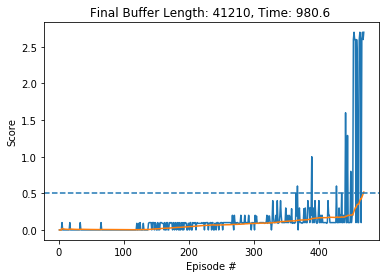

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.plot(np.arange(1, len(scores_average) + 1), scores_average)
ax.axhline(y=0.5, xmin=0.0, xmax=1.0, linestyle='--')
plt.title(f'Final Buffer Length: {len(agent1.buffer)}, Time: {run_time:<6.1f}')
plt.ylabel('Score')
plt.xlabel('Episode #')
filename = f'model_dir/tennis/maddpg_{env.session_name}'
filename += f'-PER' if USE_PER else f'-ER'
filename += f'_{PRELOAD_STEPS:d}'
if USE_PSN:
    filename += f'-PSN'
plt.savefig(filename)
plt.show()

When finished, you can close the environment.

In [9]:
env.close()

### 4: Test the Agents

Check that the agents learned by visualizing them in the Tennis Simulator.

Note: You may need to restart the IPython Kernel if it's the same kernel you used for training.

In [2]:
# Create Environment
env = UnityTennisEnv(file_name='Tennis_Linux/Tennis.x86_64', no_graphics=False)

# Restore agents with checkpoint
agent1 = Agent(env.state_size, env.action_size, 0, restore='model_dir/tennis/maddpg_last-best.pt')
agent2 = Agent(env.state_size, env.action_size, 1, restore='model_dir/tennis/maddpg_last-best.pt')

n_episodes = 5                  # play game for 5 episodes
scores = []

t0 = time.time()
for ep_i in range(n_episodes):
    score = np.zeros((2, 2))           # initialize the score (for each agent)
    obs = env.reset(train_mode=False)  # reset the environment    
    while True:
        actions1 = agent1.act(obs[0], train_mode=False, perturb_mode=False)[0] # select an action for agent 1
        actions2 = agent2.act(obs[1], train_mode=False, perturb_mode=False)[0] # select an action for agent 2
        obs_next, rewards, dones = env.step([actions1, actions2])  # send all actions to tne environment
        score += rewards               # update the score (for each agent)
        obs = obs_next                 # roll over obs to next time step
        if dones.any():
            break
    scores.append(np.max(score))

print(f'Average score over {n_episodes} episodes: {np.mean(scores):.2f}, {time.time()-t0:.2f} seconds')
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Average score over 5 episodes: 2.66, 499.65 seconds


### Future Work
1. Figure out how to make agents learn less "jerky" actions.
2. Verify Prioritized Experience Replay algo **OR** Explore why adding PER causes agents to train longer (on average) in this environment.
1. Add TensorBoard logging.
2. Explore a more complicated Environment (Soccer) that is a blend of collaboration and competition.